In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [10]:

dataset_path = os.path.dirname(os.path.abspath('__file__'))
google_path = dataset_path + r'/stock_prediction/data/GOOG.csv'

df = pd.read_csv(google_path, index_col = 'Date', parse_dates = True)

In [12]:
ts = df['Close']
ts.head(5)

Date
2019-08-14    1164.290039
2019-08-15    1167.260010
2019-08-16    1177.599976
2019-08-19    1198.449951
2019-08-20    1182.689941
Name: Close, dtype: float64

### 전처리

In [13]:
ts.isnull().sum()

0

In [14]:
ts_log = np.log(ts)

### 시계열 안전성 분석

In [15]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean() # 이동 평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동 표준편차 시계열
    
    # 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화해봅시다.
    plt.figure(figsize = (10, 6))
    orig = plt.plot(timeseries, c='b', label='Original')
    mean = plt.plot(rolmean, c='r', label='Rolling Mean')
    std = plt.plot(rolstd, c='g', label='Rolling Std')
    plt.legend()
    plt.title("Rolling Mean & Standard Derivation")
    plt.show(block=False)

In [16]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag = 'AIC')
    
    print("Results of Dickey Fuller Test")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Oservation Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

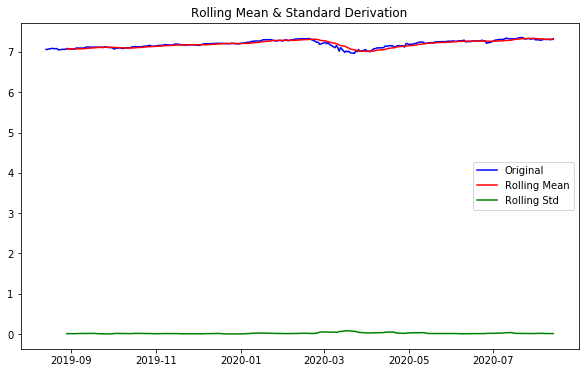

In [18]:

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [19]:
# 정량적 Augmented Dickey Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey Fuller Test
Test Statistic                -2.042062
p-value                        0.268440
#Lags Used                     9.000000
Number of Oservation Used    243.000000
Critical Value (1%)           -3.457551
Critical Value (5%)           -2.873509
Critical Value (10%)          -2.573148
dtype: float64


In [20]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model = 'multiplicative', period = 30)

In [21]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

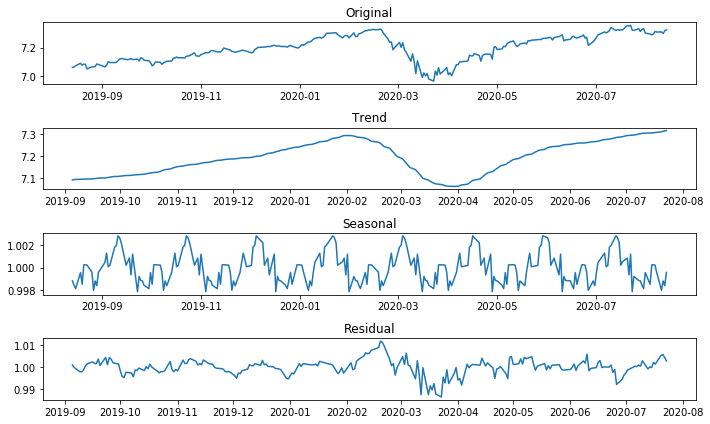

In [22]:
plt.figure(figsize = (10, 6))
plt.subplot(411)
plt.plot(ts_log)
plt.title("Original")

plt.subplot(412)
plt.plot(trend)
plt.title("Trend")

plt.subplot(413)
plt.plot(seasonal)
plt.title("Seasonal")

plt.subplot(414)
plt.plot(residual)
plt.title("Residual")

plt.tight_layout()

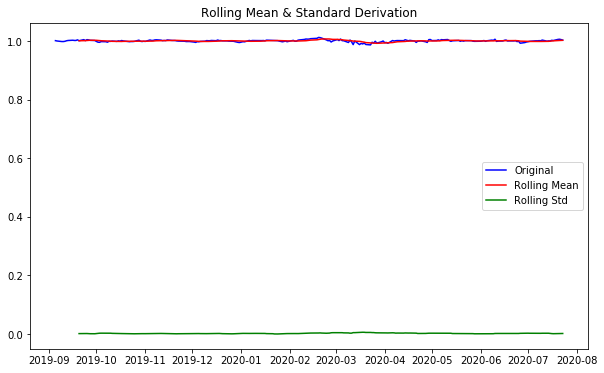

Results of Dickey Fuller Test
Test Statistic                -3.845864
p-value                        0.002471
#Lags Used                     9.000000
Number of Oservation Used    213.000000
Critical Value (1%)           -3.461429
Critical Value (5%)           -2.875207
Critical Value (10%)          -2.574054
dtype: float64


In [23]:
# Residual 안정성 확인
plot_rolling_statistics(residual)
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

### 학습, 테스트 데이터셋 분리


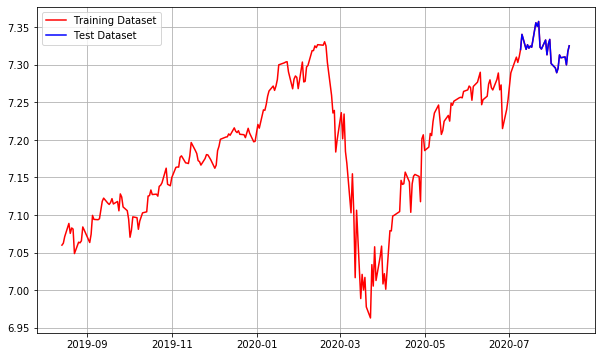

In [24]:

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label = 'Training Dataset')
plt.plot(test_data, c='b', label = 'Test Dataset')
plt.legend()
plt.show()

### 적정 ARIMA 모수 찾기


<Figure size 720x432 with 0 Axes>

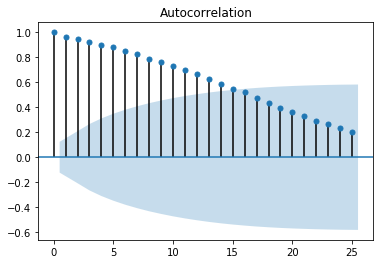

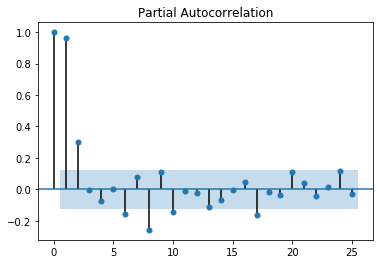

In [25]:
# ACF, PACF 그려보기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

### 차분 안정성 확인


Results of Dickey Fuller Test
Test Statistic                -4.158892
p-value                        0.000773
#Lags Used                     8.000000
Number of Oservation Used    243.000000
Critical Value (1%)           -3.457551
Critical Value (5%)           -2.873509
Critical Value (10%)          -2.573148
dtype: float64


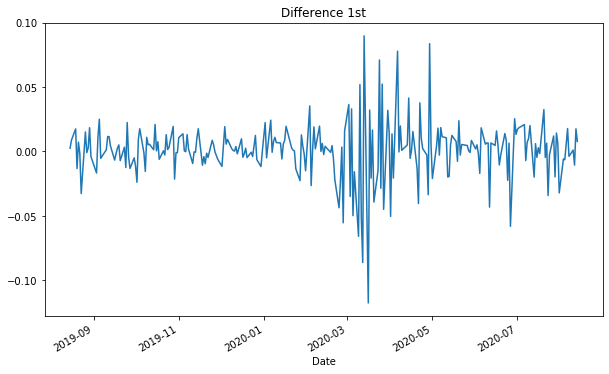

In [28]:
#차분 안정성 확인 -> d 구하기
plt.figure(figsize=(10, 6))
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
plt.show()

Results of Dickey Fuller Test
Test Statistic              -8.230775e+00
p-value                      6.071502e-13
#Lags Used                   1.000000e+01
Number of Oservation Used    2.400000e+02
Critical Value (1%)         -3.457894e+00
Critical Value (5%)         -2.873659e+00
Critical Value (10%)        -2.573229e+00
dtype: float64


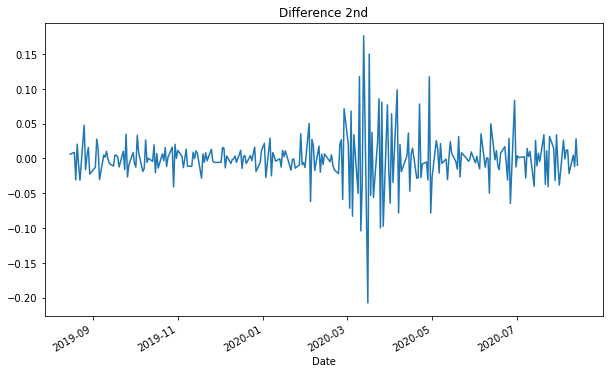

In [29]:
plt.figure(figsize=(10, 6))
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)
plt.show()

### ARIMA 모델 빌드와 훈련
### 모델 테스트 및 플로팅
### 최종 예측 모델 정확도 측정 (MAPE)

In [30]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-2)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 548.760
Method:                       css-mle   S.D. of innovations              0.021
Date:                Fri, 14 Aug 2020   AIC                          -1091.521
Time:                        14:07:50   BIC                          -1081.259
Sample:                             1   HQIC                         -1087.379
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      1.056      0.291      -0.001       0.003
ar.L1.D.Close    -0.3637      0.062     -5.889      0.000      -0.485      -0.243
                                    Root

/home/aiffel0042/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


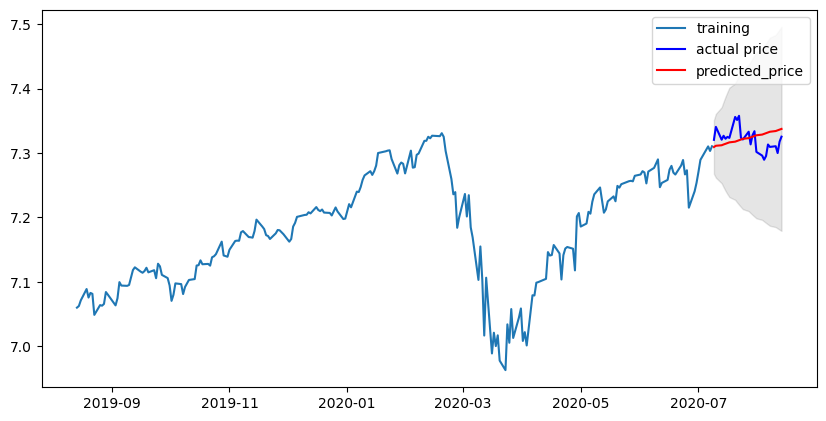

In [31]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]
fc, se, conf = fitted_m.forecast(len(test_data), alpha = 0.05)

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)


# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10, 5), dpi = 100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c = 'r', label='predicted_price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
  # [[YOUR CODE]]
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))  # [[YOUR CODE]]
print('MAE: ', mae)

rmse = math.sqrt(mse) # [[YOUR CODE]]
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc)- np.exp(test_data))/ np.abs(np.exp(test_data))) # [[YOUR CODE]]
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1193.9640182041728
MAE:  28.91995364749359
RMSE:  34.55378442666118
MAPE: 1.91%


### 테슬라 주식 예측

In [39]:
tesla_path = dataset_path + r'/stock_prediction/data/TSLA.csv'
# dataset_path + r'/stock_prediction/data/GOOG.csv'
df = pd.read_csv(tesla_path, index_col='Date', parse_dates=True)

In [41]:

ts = df['Close']
ts.head(3)

Date
2019-08-14    219.619995
2019-08-15    215.639999
2019-08-16    219.940002
Name: Close, dtype: float64

In [42]:
# 결측치 처리
ts.isnull().sum()

0

In [43]:
# 로그 처리
ts_log = np.log(ts)

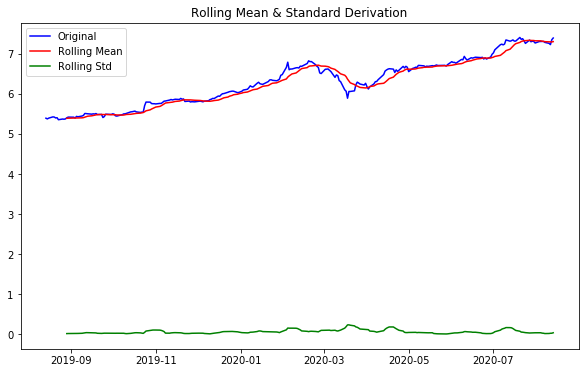

In [44]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [45]:
# 정량적 Augmented Dickey Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey Fuller Test
Test Statistic                -0.264540
p-value                        0.930379
#Lags Used                     0.000000
Number of Oservation Used    252.000000
Critical Value (1%)           -3.456569
Critical Value (5%)           -2.873079
Critical Value (10%)          -2.572919
dtype: float64


In [46]:
# 시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model = 'multiplicative', period = 30)

In [47]:

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

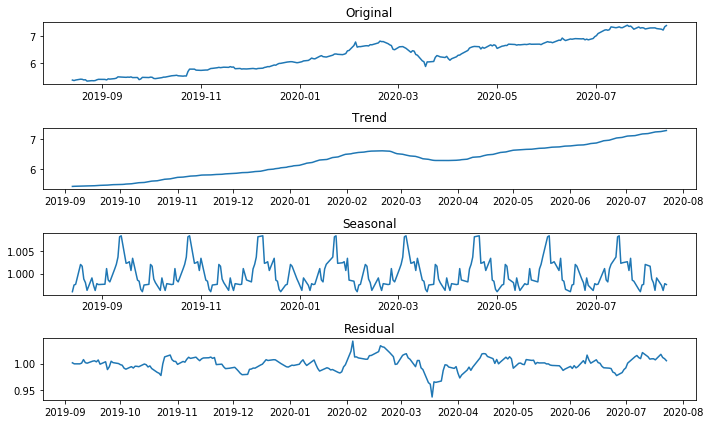

In [48]:
plt.figure(figsize = (10, 6))
plt.subplot(411)
plt.plot(ts_log)
plt.title("Original")

plt.subplot(412)
plt.plot(trend)
plt.title("Trend")

plt.subplot(413)
plt.plot(seasonal)
plt.title("Seasonal")

plt.subplot(414)
plt.plot(residual)
plt.title("Residual")

plt.tight_layout()

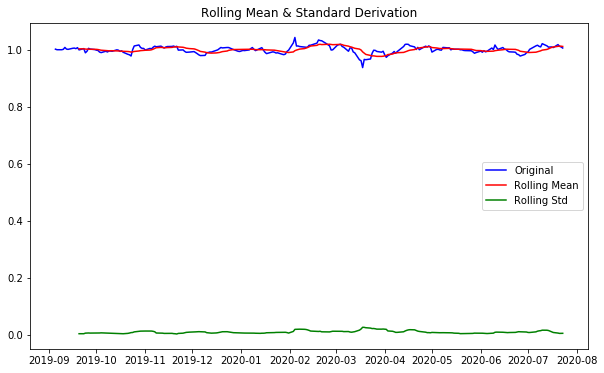

Results of Dickey Fuller Test
Test Statistic                -4.404286
p-value                        0.000292
#Lags Used                     0.000000
Number of Oservation Used    222.000000
Critical Value (1%)           -3.460154
Critical Value (5%)           -2.874649
Critical Value (10%)          -2.573757
dtype: float64


In [49]:
# Residual 안정성 확인
plot_rolling_statistics(residual)
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

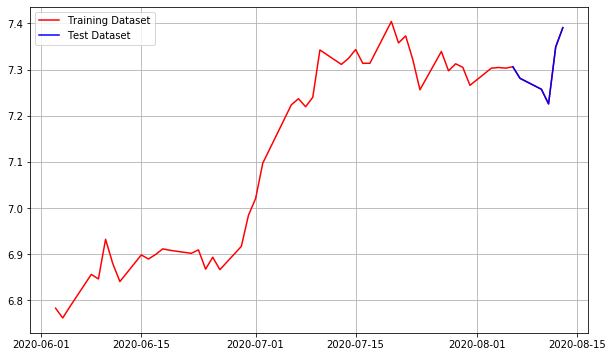

In [50]:
# 학습, 테스트 데이터셋 분리
ts_log = ts_log[int(len(ts_log)*0.8):]
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label = 'Training Dataset')
plt.plot(test_data, c='b', label = 'Test Dataset')
plt.legend()
plt.show()

<Figure size 720x432 with 0 Axes>

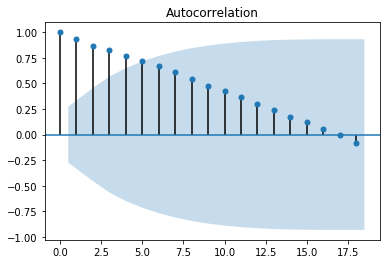

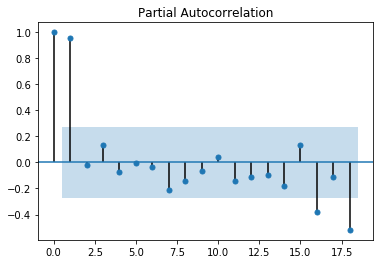

In [51]:
# 적정 ARIMA 모수 찾기
# ACF, PACF 그려보기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey Fuller Test
Test Statistic              -7.479679e+00
p-value                      4.809156e-11
#Lags Used                   0.000000e+00
Number of Oservation Used    4.900000e+01
Critical Value (1%)         -3.571472e+00
Critical Value (5%)         -2.922629e+00
Critical Value (10%)        -2.599336e+00
dtype: float64


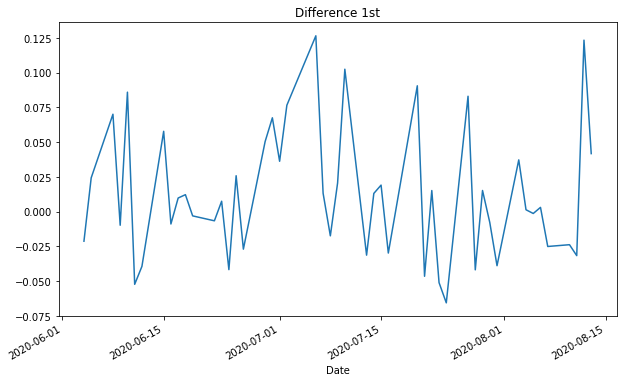

In [52]:
#차분 안정성 확인 -> d 구하기
plt.figure(figsize=(10, 6))
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
plt.show()

In [53]:
# 모델 훈련과 테스트
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-2)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                   44
Model:                 ARIMA(1, 1, 0)   Log Likelihood                  73.673
Method:                       css-mle   S.D. of innovations              0.045
Date:                Fri, 14 Aug 2020   AIC                           -141.347
Time:                        14:14:13   BIC                           -135.994
Sample:                             1   HQIC                          -139.362
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0119      0.006      1.950      0.051   -6.21e-05       0.024
ar.L1.D.Close    -0.1202      0.149     -0.807      0.420      -0.412       0.172
                                    Root

/home/aiffel0042/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


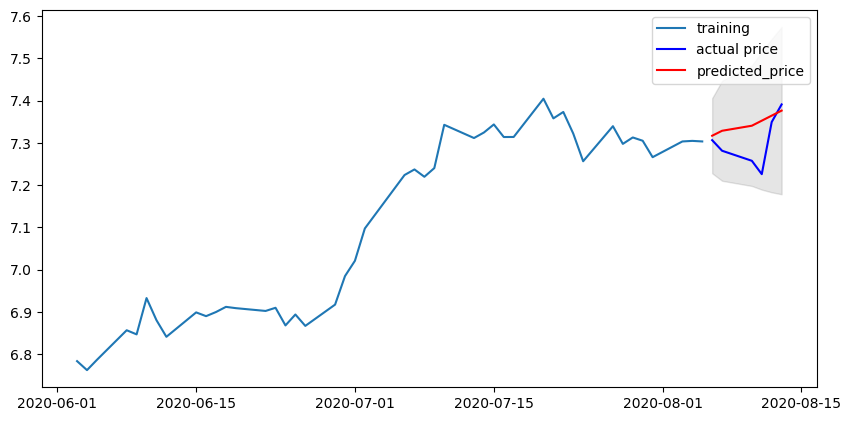

In [54]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]
fc, se, conf = fitted_m.forecast(len(test_data), alpha = 0.05)

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index = test_data.index)
lower_series = pd.Series(conf[:, 0], index = test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)


# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10, 5), dpi = 100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c = 'r', label='predicted_price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
  # [[YOUR CODE]]
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))  # [[YOUR CODE]]
print('MAE: ', mae)

rmse = math.sqrt(mse) # [[YOUR CODE]]
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc)- np.exp(test_data))/ np.abs(np.exp(test_data))) # [[YOUR CODE]]
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  9293.025558429783
MAE:  73.57340002925021
RMSE:  96.4003400327498
MAPE: 5.17%


### 구글, 테슬라 주식을 분석해보았다.
### MAPE: 1.91% ,    5.17%
### 나오는데 결과값은 좋게나오지만 뭔가 더 체그해봐야할듯하다